In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import random

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

# set text size for plots to be larger
plt.rcParams.update({"font.size": 16})

import glob
import os
import tqdm
import plot_fuctions as pf
from plot_fuctions import load_and_process_file, get_revo_count, get_combined_count, set_paths


In [3]:
%matplotlib inline

In [4]:
# change current working directory to the folder where the data is stored
cwd = os.chdir("/home/joe/ttop/cascade/")
data_path = os.getcwd() + "/data/midway_294444"
model_path = os.getcwd() + "/data/midway_full_run/model/"
image_path = os.getcwd() + "/model_analysis/analysis_images/midway_294444/"
data_directory = pf.set_paths(data_path, image_path)

In [5]:
all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.parquet')]
all_dataframes = [load_and_process_file(file_path) for file_path in all_files]
df = pd.concat(all_dataframes, ignore_index=True)
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/home/joe/ttop/cascade/data/midway_294444/model/'

In [ ]:
unique_model_count = df["Model"].nunique()
print(f"There are {unique_model_count} unique values in the 'model' column.")
get_revo_count(df)
df = get_combined_count(df)

In [4]:
# print current working directory
print("Current working directory: {0}".format(os.getcwd()))
# change current working directory
os.chdir("/home/joe/ttop/cascade/")

Current working directory: /home/joe/ttop/cascade/model_analysis


In [6]:
df = pd.read_parquet("data/midway_294444.parquet")
image_path = os.getcwd() + "/model_analysis/analysis_images/2023-04-26/"

In [6]:
# Create a dictionary to map Model values to unique numbers
model_number_mapping = {model: i for i, model in enumerate(df['Model'].unique())}

# Create a new column 'Model Number' by applying the mapping to the 'Model' column
df['Model Number'] = df['Model'].map(model_number_mapping)

In [7]:
# Get unique models from the DataFrame
unique_models = df['Model Number'].unique()

# Iterate over unique models and update Revolution values
for model in unique_models:
    if df[df['Model Number'] == model]['Revolution'].any():
        df.loc[df['Model Number'] == model, 'Revolution'] = True

In [8]:
# Filter the data based on the given conditions
filtered_df = df.loc[
    (df['Seed'] == df['Seed'].shift()) &
    (df['Security Density'] == df['Security Density'].shift()) &
    (df['Private Preference'] == df['Private Preference'].shift())
]

# Group the filtered DataFrame by Seed, Security Density, and Private Preference
grouped_df = filtered_df.groupby(['Seed', 'Security Density', 'Private Preference'])

# Initialize an empty list to store model pairs
model_pairs = []

# Iterate through the grouped DataFrame
for _, group in grouped_df:
    revolution_true_models = group[(group['Revolution'] == True) & (group['Epsilon'] == 0.2)]['Model'].unique()
    revolution_false_models = group[(group['Revolution'] == False) & (group['Epsilon'] == 1.0)]['Model'].unique()
    
    # Check if there is exactly one model with Revolution == True and one model with Revolution == False
    if len(revolution_true_models) == 1 and len(revolution_false_models) == 1:
        model_pairs.append((revolution_true_models[0], revolution_false_models[0]))

# Print the list of model pairs
print("Model Pairs:")
for pair in model_pairs:
    print(pair)
print(len(model_pairs))


Model Pairs:
('Seed 344000 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344000 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344000 SD0.02 PP -0.5 EP 0.2 Th 2.94444', 'Seed 344000 SD0.02 PP -0.5 EP 1 Th 2.94444')
('Seed 344000 SD0.02 PP -0.2 EP 0.2 Th 2.94444', 'Seed 344000 SD0.02 PP -0.2 EP 1 Th 2.94444')
('Seed 344002 SD0.02 PP -0.5 EP 0.2 Th 2.94444', 'Seed 344002 SD0.02 PP -0.5 EP 1 Th 2.94444')
('Seed 344003 SD0.02 PP -1 EP 0.2 Th 2.94444', 'Seed 344003 SD0.02 PP -1 EP 1 Th 2.94444')
('Seed 344004 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344004 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344005 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344005 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344006 SD0.02 PP -1 EP 0.2 Th 2.94444', 'Seed 344006 SD0.02 PP -1 EP 1 Th 2.94444')
('Seed 344007 SD0.02 PP -1 EP 0.2 Th 2.94444', 'Seed 344007 SD0.02 PP -1 EP 1 Th 2.94444')
('Seed 344007 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344007 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344008 SD0.02 PP -0.5 EP 0.2 Th 2.94444', 

In [ ]:
for idx in range(20):
    # Filter the DataFrame to only include rows with the selected model pairs
    selected_models = [model for pair in model_pairs for model in pair]
    filtered_df = df[df['Model'].isin(selected_models)]

    # Choose a random 10 pairs instead of all pairs
    random_pairs = random.sample(model_pairs, 9)

    # Filter the DataFrame to only include rows with the selected models
    filtered_df = df[df['Model'].isin([model for pair in random_pairs for model in pair])]

    # Melt the DataFrame to have separate columns for Active and Jail Count
    melted_df = pd.melt(
        filtered_df,
        id_vars=['Model', 'Model Number', 'Epsilon', 'Step'],
        value_vars=['Active Count', 'Jail Count'],
        var_name='Count_Type',
        value_name='Count'
    )

    # Combine Model and Count_Type columns into a new column
    melted_df['Model_Count_Type'] = melted_df['Model'] + ' - ' + melted_df['Count_Type']

    # Create a new column for pair number
    model_to_pair = {model: i + 1 for i, pair in enumerate(random_pairs) for model in pair}
    melted_df['Pair'] = melted_df['Model'].map(model_to_pair)

    # Create a color map based on the Epsilon values
    color_map = {0.1: 'red', 0.2: 'red', 1.0: 'blue'}

    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.5)

    # Create a Figure object
    fig = plt.figure(figsize=(10, 6))

    # Create the FacetGrid with the 'Pair' column
    g = sns.FacetGrid(
        data=melted_df,
        col='Pair',
        col_wrap=3,
        height=4,
        aspect=1.5,
        sharex=True,
        sharey=True,
        margin_titles=True
    )

    # Set the overall title for the FacetGrid
    g.fig.suptitle("Active and Jail Count for Model Pairs Epsilon Blue = 1.0, Red = 0.2", y=1.00, fontsize=22)

    # Plot the Active and Jail Count
    g.map_dataframe(sns.lineplot, x='Step', y='Count', hue='Epsilon', style='Count_Type', palette=color_map, legend=False)

    # Customize the titles for each graph in the facet
    g.set_titles(template="{col_name}")

    # Change the title to display the model number pair
    for ax, pair in zip(g.axes.flat, random_pairs):
        ax.set_title(f"Seed: {df[df['Model'] == pair[0]]['Seed'].unique()}, SD: {df[df['Model'] == pair[0]]['Security Density'].unique()}, PP: {df[df['Model'] == pair[0]]['Private Preference'].unique()} \nModel Pair: {df[df['Model'] == pair[0]]['Model Number'].unique()}, {df[df['Model'] == pair[1]]['Model Number'].unique()}")

    # Save the figure
    plt.savefig(image_path + f"facet_graph_{idx}.png", dpi=300, bbox_inches='tight')

    # Adjust the layout to accommodate the overall title
    g.fig.tight_layout()

    # Show the plot
    plt.show()


In [27]:
def check_models(df, model1, model2):
    # Extract Epsilon, Model Seed, Security Density and Private Preference values for each model
    epsilon1 = df[df['Model Number'] == model1]['Epsilon'].unique()[0]
    epsilon2 = df[df['Model Number'] == model2]['Epsilon'].unique()[0]
    model_seed1 = df[df['Model Number'] == model1]['Seed'].unique()[0]
    model_seed2 = df[df['Model Number'] == model2]['Seed'].unique()[0]
    security_density1 = df[df['Model Number'] == model1]['Security Density'].unique()[0]
    security_density2 = df[df['Model Number'] == model2]['Security Density'].unique()[0]
    private_preference1 = df[df['Model Number'] == model1]['Private Preference'].unique()[0]
    private_preference2 = df[df['Model Number'] == model2]['Private Preference'].unique()[0]

    print(f"Model 1: {df[df['Model Number'] == model1]['Model'].unique()}, {model1}")
    print(f"Model 1: Revolutions: {df[df['Model Number'] == model1]['Revolution'].unique()}")
    print(f"Model 1: {df[df['Model Number'] == model2]['Model'].unique()}, {model2}")
    print(f"Model 2: Revolutions: {df[df['Model Number'] == model2]['Revolution'].unique()}")

    # Model 1
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Step', y='Active Count', data=df[df['Model Number'] == model1], label=f'Active Count (Epsilon {epsilon1})', color='red')
    sns.lineplot(x='Step', y='Jail Count', data=df[df['Model Number'] == model1], label=f'Jail Count (Epsilon {epsilon1})', linestyle='--', color='red')
    sns.lineplot(x='Step', y='Active Count', data=df[df['Model Number'] == model2], label=f'Active Count (Epsilon {epsilon2})', color='blue')
    sns.lineplot(x='Step', y='Jail Count', data=df[df['Model Number'] == model2], label=f'Jail Count (Epsilon {epsilon2})', linestyle='--', color='blue')
    
    # Set the title with Model Seed, Security Density, and Private Preference
    plt.title(f'Models Seed {model_seed1}, Sec. Density {security_density1}, Priv. Pref. {private_preference1}')


    plt.ylim(0, 1120)
    plt.xlim(0, 500)
    plt.legend()

    # Save the figure
    plt.savefig(image_path + f"model_{model1}_{model2}.png", dpi=300, bbox_inches='tight')
    
    plt.show()


Model 1: ['Seed 344031 SD0.02 PP -0.5 EP 0.2 Th 2.94444'], 253
Model 1: Revolutions: [ True]
Model 1: ['Seed 344031 SD0.02 PP -0.5 EP 1 Th 2.94444'], 3648
Model 2: Revolutions: [False]


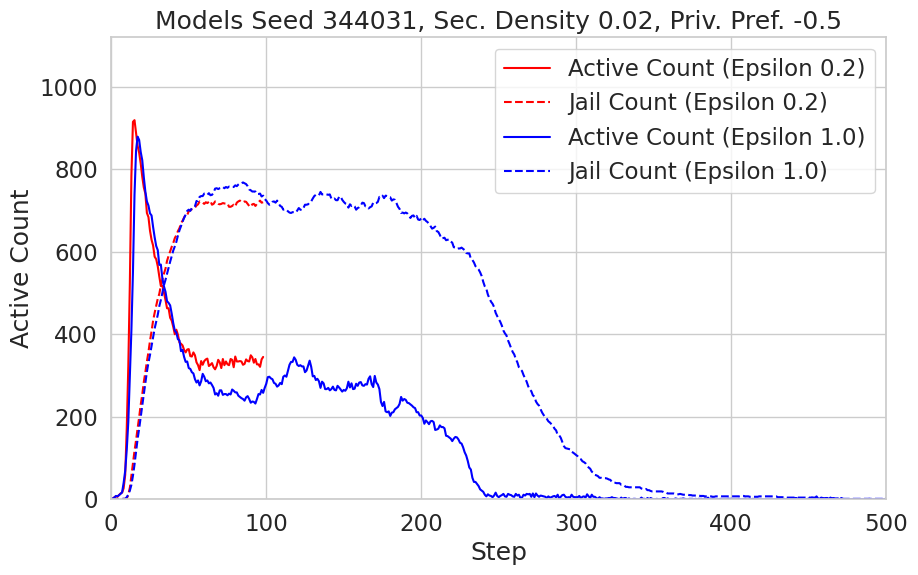

In [28]:
check_models(df, 253, 3648)

In [49]:
df[df['Model Number'] == 253][['Model Number', 'Step', 'Active Count', 'Oppose Count', 'Jail Count']].head(60)
df[df['Model Number'] == 3648][['Model Number', 'Step', 'Active Count', 'Oppose Count', 'Jail Count']].head(60)

,Model Number,Step,Active Count,Oppose Count,Jail Count
1323168,3648,0,0,0,0
1323169,3648,1,2,4,0
1323170,3648,2,4,2,0
1323171,3648,3,8,7,0
1323172,3648,4,7,7,0
1323173,3648,5,10,7,0
1323174,3648,6,13,11,1
1323175,3648,7,17,17,1
1323176,3648,8,40,11,1
1323177,3648,9,69,18,1


Model 1: ['Seed 344089 SD0.01 PP -1 EP 0.2 Th 2.94444'], 1189
Model 1: Revolutions: [ True]
Model 1: ['Seed 344089 SD0.01 PP -1 EP 0.1 Th 2.94444'], 4507
Model 2: Revolutions: [ True]


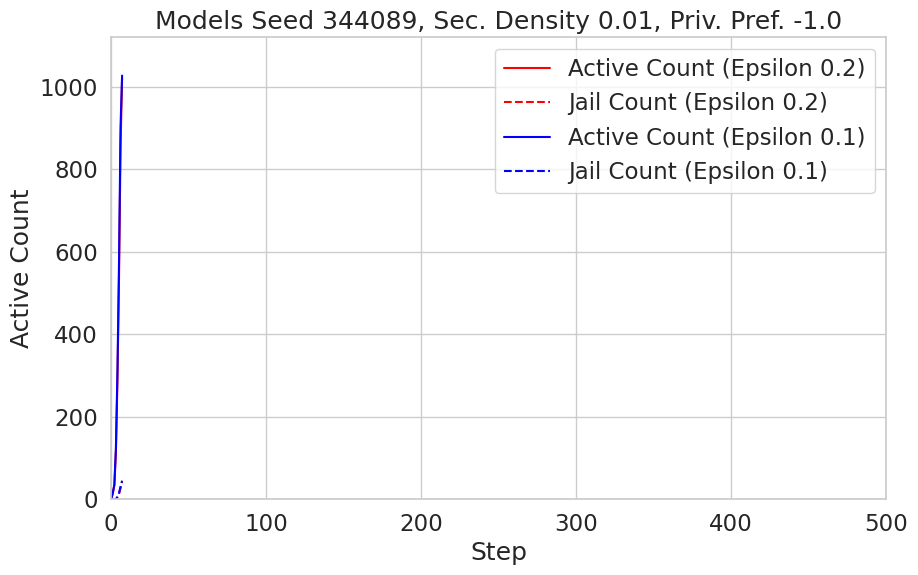

In [77]:
check_models(df, 1189, 4507)

In [7]:
ag_df_1 = pd.read_parquet("data/2023-04-26/agent/agent_seed_344031_pp_-0.5_sd0.02_ep_0.2_th2.94444.parquet")
ag_df_2 = pd.read_parquet("data/2023-04-26/agent/agent_seed_344031_pp_-0.5_sd0.02_ep_1_th2.94444.parquet")

FileNotFoundError: [Errno 2] No such file or directory: '/home/joe/ttop/cascade/model_analysis/analysis_images/2023-04-26/Proportion of Agents with Activation Level Above 0.75 per Step.png'

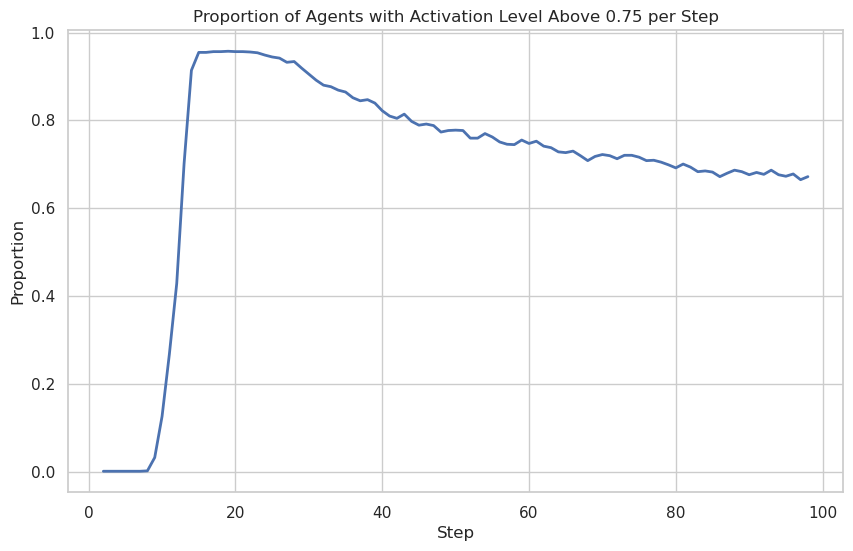

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df = ag_df_1

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Calculate the proportion of agents with an activation_level above 0.75 for each step
above_75 = df_reset[df_reset['active_level'] > 0.75].groupby('Step').size()
total_agents = df_reset.groupby('Step').size()
proportion_above_75 = above_75 / total_agents
proportion_above_75 = proportion_above_75.reset_index(name='proportion')

# Line plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x="Step", y="proportion", data=proportion_above_75, linewidth=2)

plt.title('Proportion of Agents with Activation Level Above 0.75 per Step')
plt.xlabel('Step')
plt.ylabel('Proportion')

# save the figure
plt.savefig(image_path + "Proportion of Agents with Activation Level Above 0.75 per Step.png", dpi=300, bbox_inches='tight')

plt.show()


In [15]:
max(proportion_above_75.proportion)

nan

FileNotFoundError: [Errno 2] No such file or directory: '/home/joe/ttop/cascade/model_analysis/analysis_images/2023-04-26/Proportion of Agents with Activation Level Above 0.75 per Step.png'

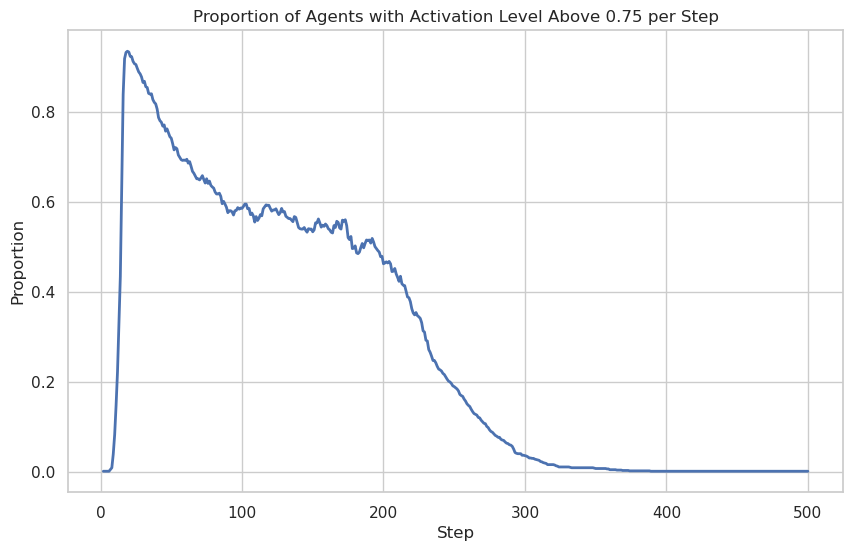

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df = ag_df_2

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Calculate the proportion of agents with an activation_level above 0.75 for each step
above_75 = df_reset[df_reset['active_level'] > 0.75].groupby('Step').size()
total_agents = df_reset.groupby('Step').size()
proportion_above_75 = above_75 / total_agents
proportion_above_75 = proportion_above_75.reset_index(name='proportion')

# Line plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x="Step", y="proportion", data=proportion_above_75, linewidth=2)

plt.title('Proportion of Agents with Activation Level Above 0.75 per Step')
plt.xlabel('Step')
plt.ylabel('Proportion')

# save the figure
plt.savefig(image_path + "Proportion of Agents with Activation Level Above 0.75 per Step.png", dpi=300, bbox_inches='tight')

plt.show()


In [10]:
ag_df_1.head()

pos condition   opinion  activation  private_preference  \
Step AgentID                                                                 
0    1          [0, 3]   Support -0.351728    0.412963            0.358439   
     2        [38, 27]   Support  0.524957    0.628306           -0.518933   
     3          [7, 7]   Support  1.157801    0.760933           -1.151349   
     4        [15, 37]   Support -1.074958    0.254461            1.081452   
     5         [21, 7]   Support  0.387175    0.595602           -0.380964   

               epsilon  oppose_threshold  active_threshold  jail_sentence  \
Step AgentID                                                                
0    1       -0.079540          2.941502          3.059267            0.0   
     2       -0.046827          2.864739          2.905786            0.0   
     3       -0.311303          2.964809          2.997987            0.0   
     4        0.104377          2.736812          3.027027            0.0   
     5       -0.081585          2.804335          2.871532            0.0   

              actives_in_vision  ... arrest_prob active_level  oppose_level  \
Step AgentID                     ...                                          
0    1                      1.0  ...    0.999854    -0.967901     -0.964050   
     2                      1.0  ...    0.999987    -0.915340     -0.912105   
     3                      1.0  ...    0.999582    -0.862552     -0.858582   
     4                      1.0  ...    0.999994    -0.983724     -0.978364   
     5                      1.0  ...    0.999998    -0.923036     -0.918125   

              flip  ever_flipped  model_seed  model_security_density  \
Step AgentID                                                           
0    1        None         False      344031                    0.02   
     2        None         False      344031                    0.02   
     3        None         False      344031                    0.02   
     4        None         False      344031                    0.02   
     5        None         False      344031                    0.02   

             model_private_preference model_epsilon  model_threshold  
Step AgentID                                                          
0    1                           -0.5           0.2          2.94444  
     2                           -0.5           0.2          2.94444  
     3                           -0.5           0.2          2.94444  
     4                           -0.5           0.2          2.94444  
     5                           -0.5           0.2          2.94444  

[5 rows x 24 columns]

In [59]:
def plot_kde_thre(ag_df):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create the KDE plot for oppose_threshold and active_threshold
    plt.figure(figsize=(10, 6))
    sns.kdeplot(ag_df['oppose_threshold'], color='blue', fill=True, label='Oppose Threshold')
    sns.kdeplot(ag_df['active_threshold'], color='red', fill=True, label='Active Threshold')


    # Customize the plot
    plt.title(f'KDE Plot for Oppose and Active Thresholds for Epsilon {ag_df["model_epsilon"].unique()}')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.legend()

    # Save the figure
    plt.savefig(image_path + f"kde_plot_thresh_{ag_df['model_epsilon'].unique()}.png", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

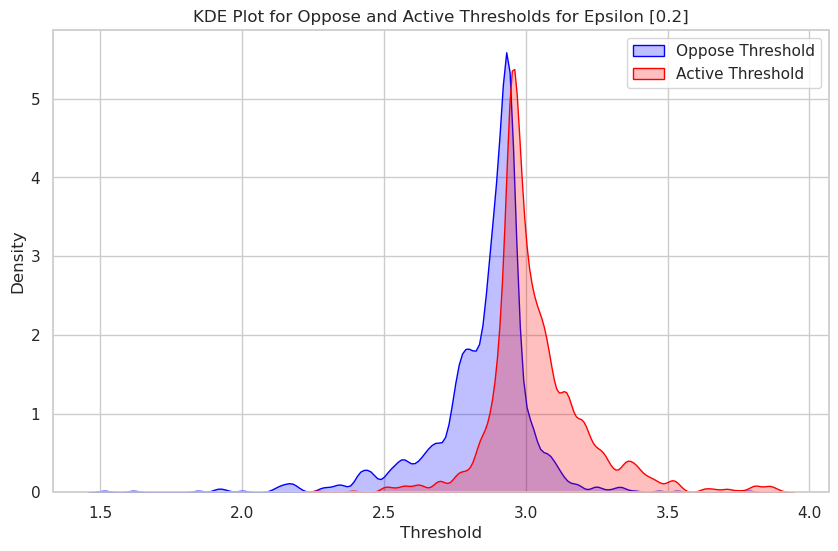

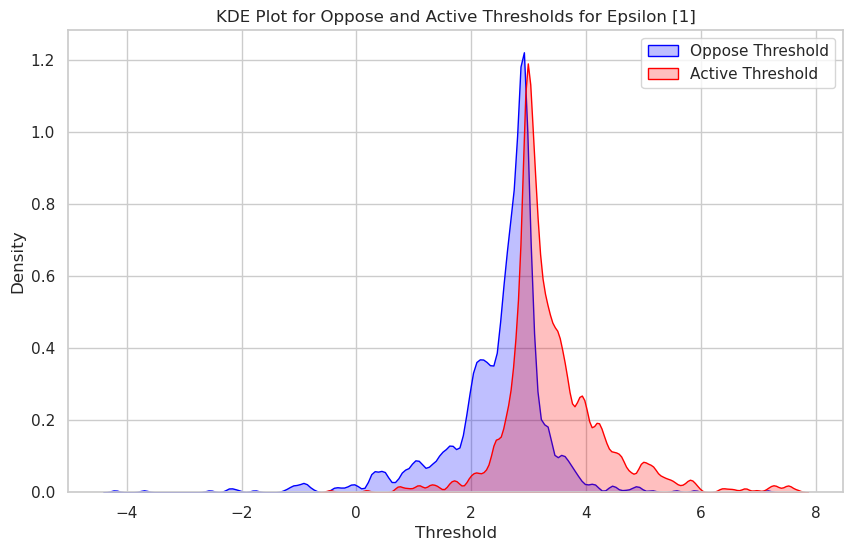

In [60]:
plot_kde_thre(ag_df_1)
plot_kde_thre(ag_df_2)

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def plot_kde_thre_double(ag_df, ag_df_2):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create a custom color palette
    cmr_colors = sns.color_palette("CMRmap_r", 10)
    
    # Create the KDE plot for oppose_threshold and active_threshold
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(ag_df['oppose_threshold'], color=cmr_colors[2], fill=True, label='Oppose Threshold Epsilon 0.2', ax=ax)
    sns.kdeplot(ag_df['active_threshold'], color=cmr_colors[4], fill=True, label='Active Threshold Epsilon 0.2', ax=ax)
    sns.kdeplot(ag_df_2['oppose_threshold'], color=cmr_colors[7], fill=True, label='Oppose Threshold Epsilon 1.0', ax=ax)
    sns.kdeplot(ag_df_2['active_threshold'], color=cmr_colors[9], fill=True, label='Active Threshold Epsilon 1.0', ax=ax)

    # Customize the plot
    plt.title('KDE Plot for Oppose and Active Thresholds for Two Epsilon Distributions of Seed 344031')
    plt.xlabel('Threshold')
    plt.ylabel('Density')

    # Create the inset
    axins = inset_axes(ax, width="40%", height="60%", loc="upper left", borderpad=5)
    axins.set_xlabel('Threshold')
    sns.kdeplot(ag_df['oppose_threshold'], color=cmr_colors[2], fill=True, ax=axins)
    sns.kdeplot(ag_df['active_threshold'], color=cmr_colors[4], fill=True, ax=axins)
    sns.kdeplot(ag_df_2['oppose_threshold'], color=cmr_colors[7], fill=True, ax=axins)
    sns.kdeplot(ag_df_2['active_threshold'], color=cmr_colors[9], fill=True, ax=axins)

    # Set inset axis limits
    axins.set_xlim(2, 4)
    axins.set_ylim(0, 1.5)

    # Move the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.savefig(image_path + "Oppose Active Thresh 2 ep 253 3648.png", dpi=300, bbox_inches="tight")

    # Display the plot
    plt.show()

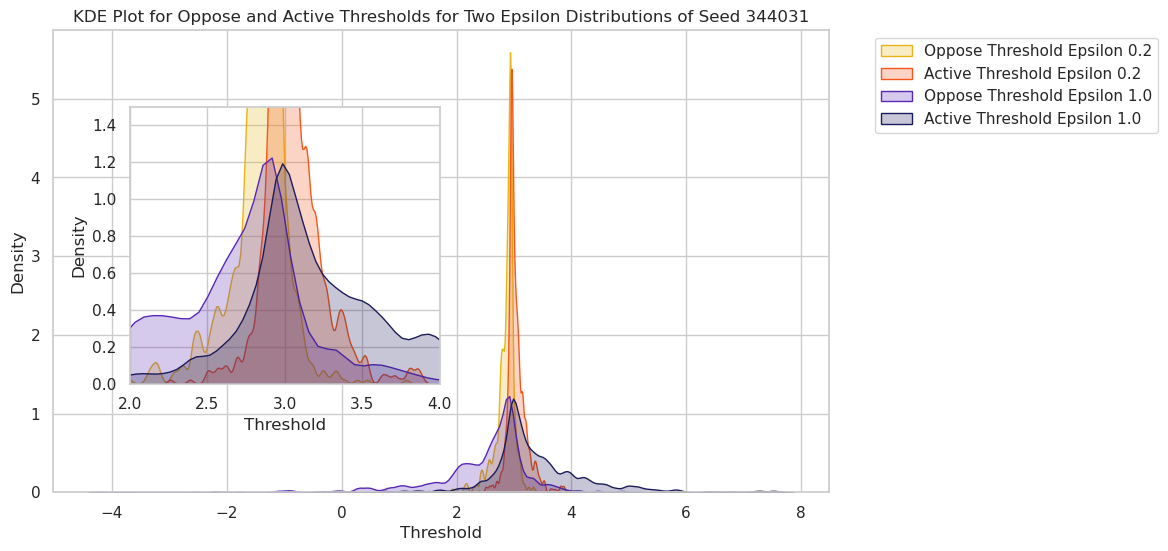

In [43]:
plot_kde_thre_double(ag_df_1, ag_df_2)

In [ ]:
def plot_kde_act(ag_df):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create the KDE plot for oppose_threshold and active_threshold
    plt.figure(figsize=(10, 6))
    sns.kdeplot(ag_df['oppose_level'], color='blue', fill=True, label='Oppose Threshold')
    sns.kdeplot(ag_df['active_level'], color='red', fill=True, label='Active Threshold')

    # Customize the plot
    plt.title('KDE Plot for Oppose and Active Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.legend()

    # Save the figure
    plt.savefig(image_path + "kde_plot_act.png", dpi=300, bbox_inches='tight')
    # Display the plot
    plt.show()

# Replace "ag_df" with the actual DataFrame variable name

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

def plot_kde_act_animated(ag_df, steps):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create a function to update the plot at each time step
    def update(t):
        plt.clf()
        if t in ag_df.index:
            current_df = ag_df.loc[t]
        else:
            return
        sns.kdeplot(current_df['oppose_level'], color='blue', fill=True, label='Oppose Threshold')
        sns.kdeplot(current_df['active_level'], color='red', fill=True, label='Active Threshold')
        plt.title(f'KDE Plot for Oppose and Active Thresholds at Time Step {t}')
        plt.xlabel('Threshold')
        plt.ylabel('Density')
        plt.legend()

    # Create the animated plot
    fig = plt.figure(figsize=(10, 6))
    ani = FuncAnimation(fig, update, frames=range(len(ag_df.index)), interval=200)

    # Save the animation as a GIF file
    ani.save("kde_animation.gif", writer=PillowWriter(fps=15))

    # Display the plot
    plt.show()

In [105]:
plot_kde_act_animated(ag_df_1, 500)

<IPython.core.display.Javascript object>

: 

: 

In [16]:
ag_df_1.head()

pos condition   opinion  activation  private_preference  \
Step AgentID                                                                 
0    1          [0, 3]   Support -0.351728    0.412963            0.358439   
     2        [38, 27]   Support  0.524957    0.628306           -0.518933   
     3          [7, 7]   Support  1.157801    0.760933           -1.151349   
     4        [15, 37]   Support -1.074958    0.254461            1.081452   
     5         [21, 7]   Support  0.387175    0.595602           -0.380964   

               epsilon  oppose_threshold  active_threshold  jail_sentence  \
Step AgentID                                                                
0    1       -0.079540          2.941502          3.059267            0.0   
     2       -0.046827          2.864739          2.905786            0.0   
     3       -0.311303          2.964809          2.997987            0.0   
     4        0.104377          2.736812          3.027027            0.0   
     5       -0.081585          2.804335          2.871532            0.0   

              actives_in_vision  ... arrest_prob active_level  oppose_level  \
Step AgentID                     ...                                          
0    1                      1.0  ...    0.999854    -0.967901     -0.964050   
     2                      1.0  ...    0.999987    -0.915340     -0.912105   
     3                      1.0  ...    0.999582    -0.862552     -0.858582   
     4                      1.0  ...    0.999994    -0.983724     -0.978364   
     5                      1.0  ...    0.999998    -0.923036     -0.918125   

              flip  ever_flipped  model_seed  model_security_density  \
Step AgentID                                                           
0    1        None         False      344031                    0.02   
     2        None         False      344031                    0.02   
     3        None         False      344031                    0.02   
     4        None         False      344031                    0.02   
     5        None         False      344031                    0.02   

             model_private_preference model_epsilon  model_threshold  
Step AgentID                                                          
0    1                           -0.5           0.2          2.94444  
     2                           -0.5           0.2          2.94444  
     3                           -0.5           0.2          2.94444  
     4                           -0.5           0.2          2.94444  
     5                           -0.5           0.2          2.94444  

[5 rows x 24 columns]

In [17]:
ag_df_2.head()

pos condition   opinion  activation  private_preference  \
Step AgentID                                                                 
0    1          [0, 3]   Support -0.351728    0.412963            0.358439   
     2        [38, 27]   Support  0.524957    0.628306           -0.518933   
     3          [7, 7]   Support  1.157801    0.760933           -1.151349   
     4        [15, 37]   Support -1.074958    0.254461            1.081452   
     5         [21, 7]   Support  0.387175    0.595602           -0.380964   

               epsilon  oppose_threshold  active_threshold  jail_sentence  \
Step AgentID                                                                
0    1       -0.397699          2.929748          3.518573            0.0   
     2       -0.234134          2.545936          2.751171            0.0   
     3       -1.556515          3.046286          3.212173            0.0   
     4        0.521883          1.906301          3.357374            0.0   
     5       -0.407927          2.243913          2.579898            0.0   

              actives_in_vision  ... arrest_prob active_level  oppose_level  \
Step AgentID                     ...                                          
0    1                      1.0  ...    0.999385    -0.978959     -0.963173   
     2                      1.0  ...    0.999961    -0.902540     -0.882944   
     3                      1.0  ...    0.959413    -0.845802     -0.827996   
     4                      1.0  ...    0.999999    -0.988252     -0.951720   
     5                      1.0  ...    0.999984    -0.899578     -0.864900   

              flip  ever_flipped  model_seed  model_security_density  \
Step AgentID                                                           
0    1        None         False      344031                    0.02   
     2        None         False      344031                    0.02   
     3        None         False      344031                    0.02   
     4        None         False      344031                    0.02   
     5        None         False      344031                    0.02   

             model_private_preference model_epsilon  model_threshold  
Step AgentID                                                          
0    1                           -0.5             1          2.94444  
     2                           -0.5             1          2.94444  
     3                           -0.5             1          2.94444  
     4                           -0.5             1          2.94444  
     5                           -0.5             1          2.94444  

[5 rows x 24 columns]

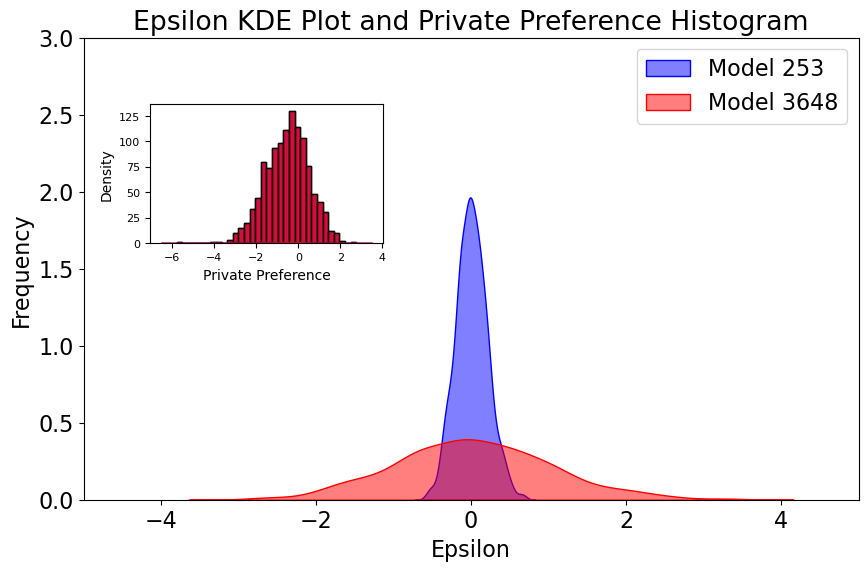

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# For demonstration purposes, let's use the same DataFrame
df1 = ag_df_1.query('Step == 0')
df2 = ag_df_2.query('Step == 0')

# Create a figure and axes for the main plot and the inset plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms and kde plots for both DataFrames
sns.kdeplot(df1['epsilon'], color='blue', alpha=0.5, fill=True, ax=ax, label='Model 253')
sns.kdeplot(df2['epsilon'], color='red', alpha=0.5, fill=True, ax=ax, label='Model 3648')

# Customize the main plot
ax.set_title('Epsilon KDE Plot and Private Preference Histogram')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Frequency')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 3)
ax.legend()

# Create an inset axes for the Private Preference plot
axins = inset_axes(ax, width="30%", height="30%", loc="upper left", borderpad=3)
# axins text size reduced
axins.tick_params(axis='both', which='major', labelsize=8)
# axins axis titles reduced
axins.set_xlabel('Private Preference', fontsize=10)
axins.set_ylabel('Density', fontsize=10)
# Plot the histogram for the Private Preference column
sns.histplot(df1['private_preference'], color='blue', ax=axins, label='DataFrame 1')
sns.histplot(df2['private_preference'], color='red', ax=axins, label='DataFrame 2')
axins.set_xlabel('Private Preference')

# Plot the inset graph for the Private Preference column
sns.kdeplot(df1['private_preference'], color='blue', ax=axins, fill=True, label='DataFrame 1')
sns.kdeplot(df2['private_preference'], color='red', ax=axins, fill=True, label='DataFrame 2')

# Customize the inset plot
axins.set_ylabel('Density')

# Save the figure
plt.savefig(image_path + "Epsilon KDE Plot and Private Preference Histogram.png", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


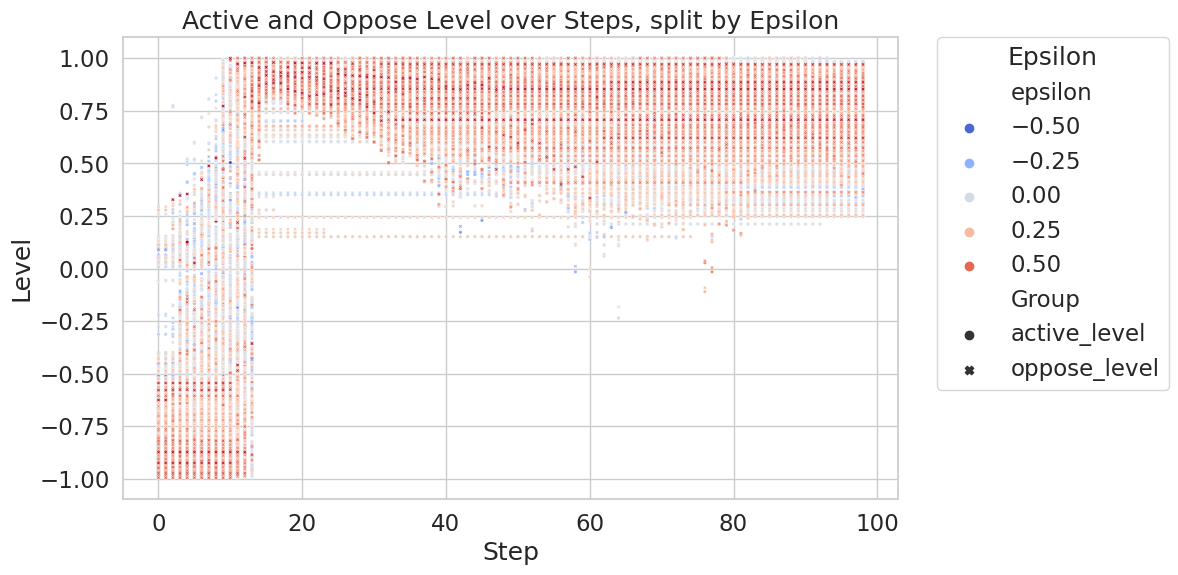

In [58]:
# Reset the index to get the 'Step' column
df_reset = ag_df_1.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step', 'epsilon'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set(style="whitegrid")
sns.set_palette("coolwarm")
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(x="Step", y="Level", hue="epsilon", palette="coolwarm", style="Group",
                     s=2, alpha=0.1, hue_order=sorted(df_long["epsilon"].unique()),
                     data=df_long)
ax.set_title('Active and Oppose Level over Steps, split by Epsilon')

# Calculate the average levels for each epsilon value
batch_avgs = df_long.groupby(["Step", "Group", "epsilon"]).mean().reset_index()

# Plot the averages
avg_data = sns.scatterplot(x="Step", y="Level", hue="epsilon", palette="coolwarm", style="Group",
                           s=6, data=batch_avgs, legend=False)

# Remove the default legend
ax.get_legend().remove()

# Create a custom legend with the title 'Epsilon'
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[0:], labels[0:], title="Epsilon", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save the figure at 300 dpi
plt.savefig(
    "active_oppose_level_steps_avg_by_ep.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


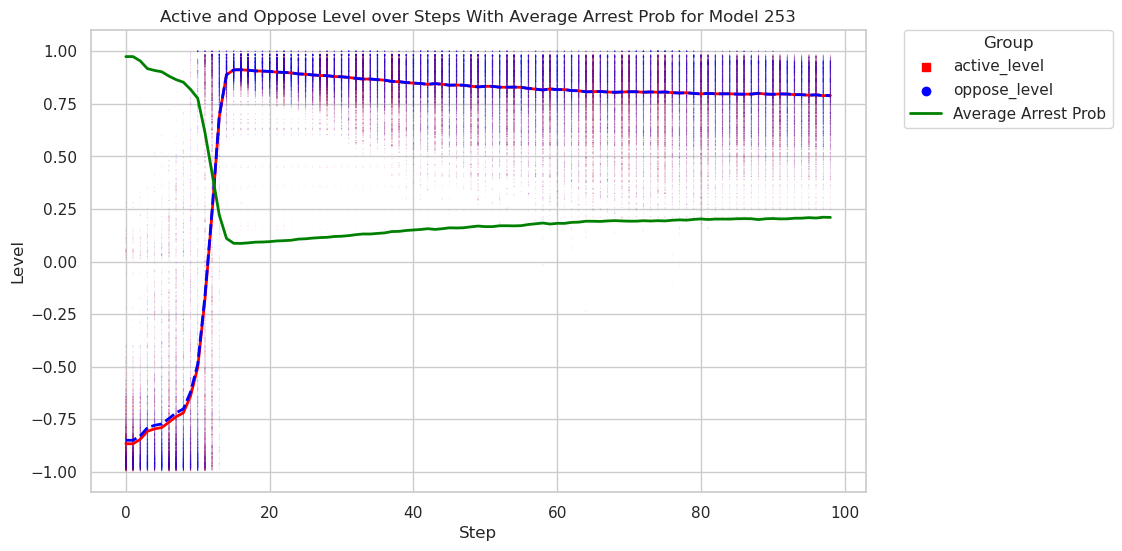

In [84]:
df = ag_df_1

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Define custom palette for the groups
custom_palette = {"active_level": "red", "oppose_level": "blue"}

full_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group",
                             s=1, alpha=0.05, markers={"active_level": "s", "oppose_level": "o"},
                             data=df_long).set(title='Active and Oppose Level over Steps')

# Calculate the average levels for each group
batch_avgs = df_long.groupby(["Step", "Group"]).mean().reset_index()

# Plot the averages as lines
avg_data = sns.lineplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group", linewidth=2,
                        data=batch_avgs, legend=False)

# Calculate the average arrest_prob for each step
avg_arrest_prob = df_reset.groupby('Step')['arrest_prob'].mean()

# Plot the average arrest_prob
plt.plot(avg_arrest_prob.index, avg_arrest_prob, color='green', linewidth=2, label='Average Arrest Prob')

# Add a legend
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Title
plt.title('Active and Oppose Level over Steps With Average Arrest Prob for Model 253')

# save the figure
plt.savefig(image_path + "Active and Oppose Level over Steps 253.png", dpi=300, bbox_inches='tight')

plt.show()


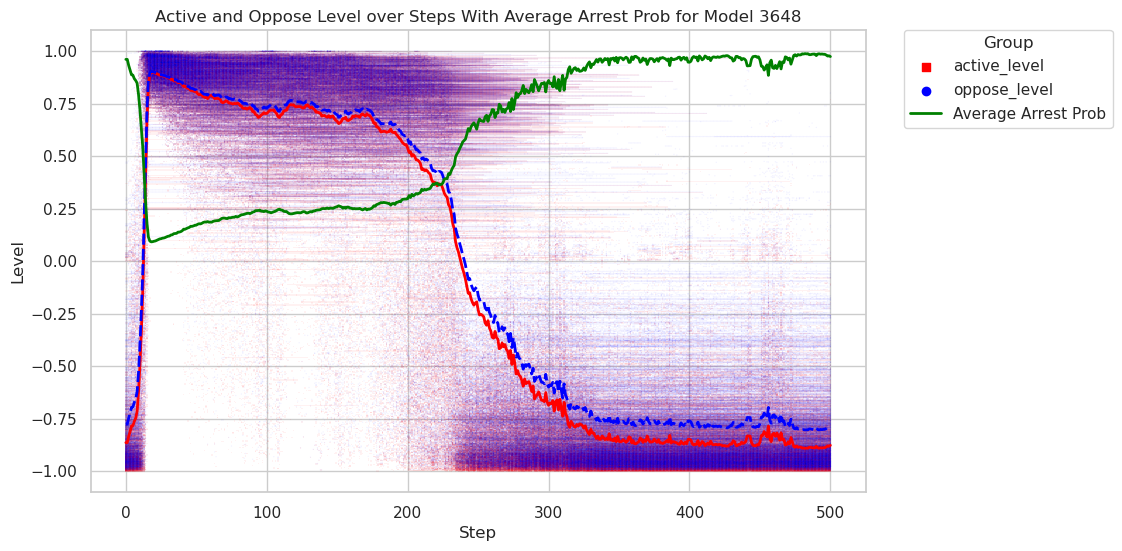

In [81]:
df = ag_df_2

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# Define custom palette for the groups
custom_palette = {"active_level": "red", "oppose_level": "blue"}

full_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group",
                             s=1, alpha=0.05, markers={"active_level": "s", "oppose_level": "o"},
                             data=df_long).set(title='Active and Oppose Level over Steps')

# Calculate the average levels for each group
batch_avgs = df_long.groupby(["Step", "Group"]).mean().reset_index()

# Plot the averages as lines
avg_data = sns.lineplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group", linewidth=2,
                        data=batch_avgs, legend=False)

# Calculate the average arrest_prob for each step
avg_arrest_prob = df_reset.groupby('Step')['arrest_prob'].mean()

# Plot the average arrest_prob
plt.plot(avg_arrest_prob.index, avg_arrest_prob, color='green', linewidth=2, label='Average Arrest Prob')

# Add a legend
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Title
plt.title('Active and Oppose Level over Steps With Average Arrest Prob for Model 3648')


# save the figure
plt.savefig(image_path + "Active and Oppose Level over Steps 3648.png", dpi=300, bbox_inches='tight')

plt.show()


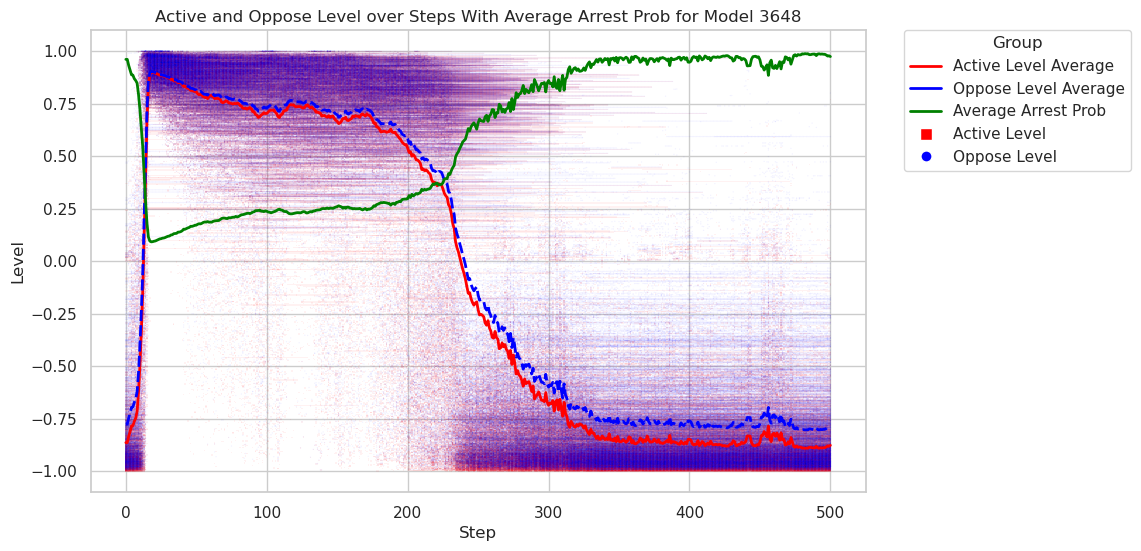

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = ag_df_2

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# Define custom palette for the groups
custom_palette = {"active_level": "red", "oppose_level": "blue"}

full_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group",
                             s=1, alpha=0.05, markers={"active_level": "s", "oppose_level": "o"},
                             data=df_long).set(title='Active and Oppose Level over Steps')

# Calculate the average levels for each group
batch_avgs = df_long.groupby(["Step", "Group"]).mean().reset_index()

# Plot the averages as lines
avg_data = sns.lineplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group", linewidth=2,
                        data=batch_avgs, legend=False)

# Calculate the average arrest_prob for each step
avg_arrest_prob = df_reset.groupby('Step')['arrest_prob'].mean()

# Plot the average arrest_prob
plt.plot(avg_arrest_prob.index, avg_arrest_prob, color='green', linewidth=2, label='Average Arrest Prob')

# Add a custom legend
legend_elements = [Line2D([0], [0], color=custom_palette["active_level"], lw=2, label='Active Level Average'),
                   Line2D([0], [0], color=custom_palette["oppose_level"], lw=2, label='Oppose Level Average'),
                   Line2D([0], [0], color='green', lw=2, label='Average Arrest Prob'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=custom_palette["active_level"], markersize=8, label='Active Level'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette["oppose_level"], markersize=8, label='Oppose Level')]

plt.legend(handles=legend_elements, title="Group", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Title
plt.title('Active and Oppose Level over Steps With Average Arrest Prob for Model 3648')


# save the figure
plt.savefig(image_path + "Active and Oppose Level over Steps 3648.png", dpi=300, bbox_inches='tight')

plt.show()


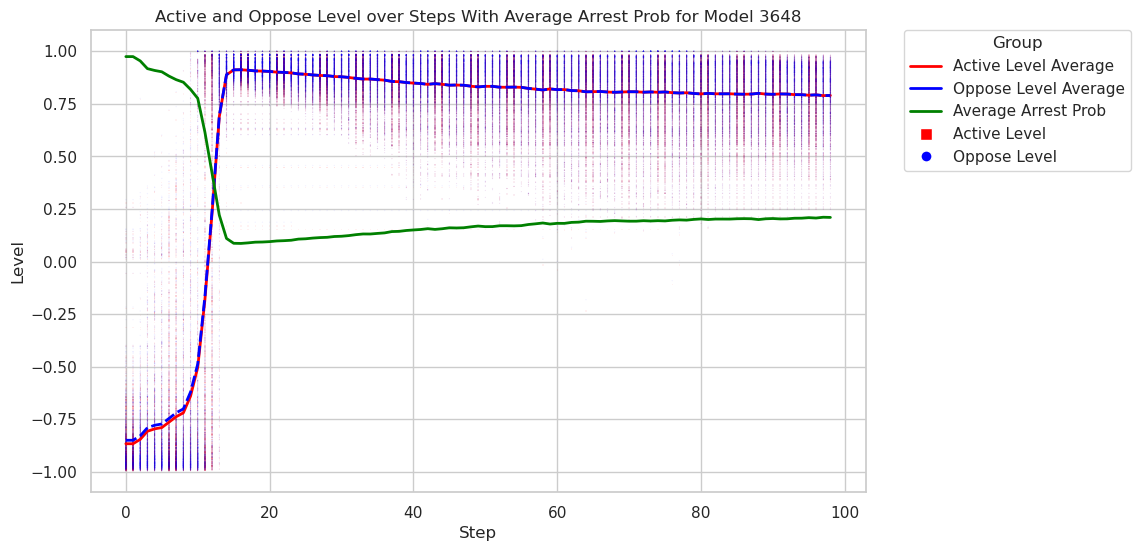

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = ag_df_1

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# Define custom palette for the groups
custom_palette = {"active_level": "red", "oppose_level": "blue"}

full_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group",
                             s=1, alpha=0.05, markers={"active_level": "s", "oppose_level": "o"},
                             data=df_long).set(title='Active and Oppose Level over Steps')

# Calculate the average levels for each group
batch_avgs = df_long.groupby(["Step", "Group"]).mean().reset_index()

# Plot the averages as lines
avg_data = sns.lineplot(x="Step", y="Level", hue="Group", palette=custom_palette, style="Group", linewidth=2,
                        data=batch_avgs, legend=False)

# Calculate the average arrest_prob for each step
avg_arrest_prob = df_reset.groupby('Step')['arrest_prob'].mean()

# Plot the average arrest_prob
plt.plot(avg_arrest_prob.index, avg_arrest_prob, color='green', linewidth=2, label='Average Arrest Prob')

# Add a custom legend
legend_elements = [Line2D([0], [0], color=custom_palette["active_level"], lw=2, label='Active Level Average'),
                   Line2D([0], [0], color=custom_palette["oppose_level"], lw=2, label='Oppose Level Average'),
                   Line2D([0], [0], color='green', lw=2, label='Average Arrest Prob'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor=custom_palette["active_level"], markersize=8, label='Active Level'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette["oppose_level"], markersize=8, label='Oppose Level')]

plt.legend(handles=legend_elements, title="Group", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Title
plt.title('Active and Oppose Level over Steps With Average Arrest Prob for Model 3648')


# save the figure
plt.savefig(image_path + "Active and Oppose Level over Steps 253.png", dpi=300, bbox_inches='tight')

plt.show()


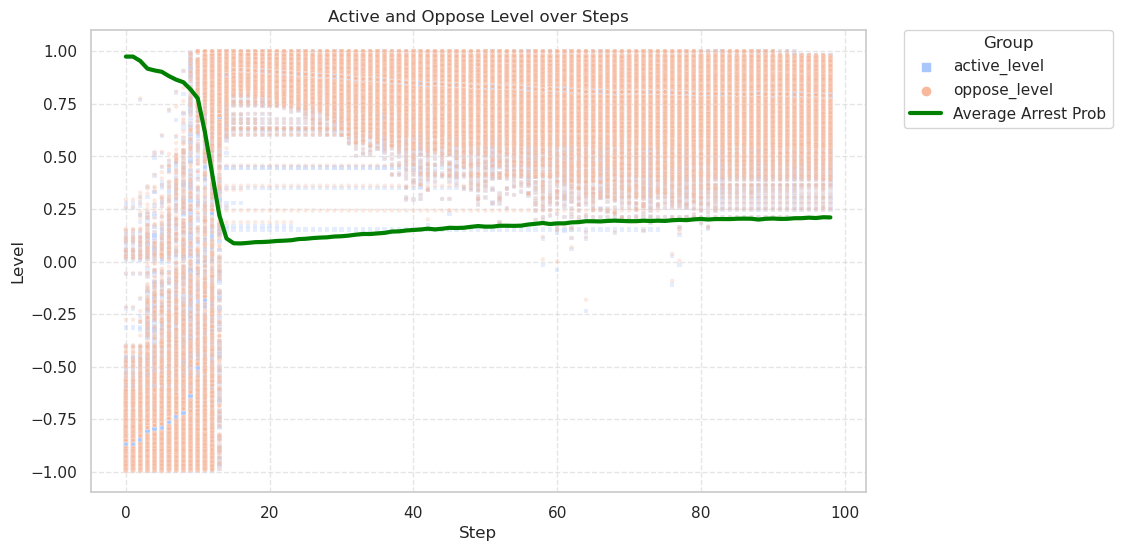

In [63]:
df = ag_df_1

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

full_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette="coolwarm", style="Group",
                             s=10, alpha=0.3, markers={"active_level": "s", "oppose_level": "o"},
                             data=df_long).set(title='Active and Oppose Level over Steps')

# Calculate the average levels for each group
batch_avgs = df_long.groupby(["Step", "Group"]).mean().reset_index()

# Plot the averages
avg_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette="coolwarm", style="Group", s=10,
                           markers={"active_level": "s", "oppose_level": "o"}, data=batch_avgs, legend=False)

# Calculate the average arrest_prob for each step
avg_arrest_prob = df_reset.groupby('Step')['arrest_prob'].mean()

# Plot the average arrest_prob
plt.plot(avg_arrest_prob.index, avg_arrest_prob, color='green', linewidth=3, label='Average Arrest Prob')

# Add a legend
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

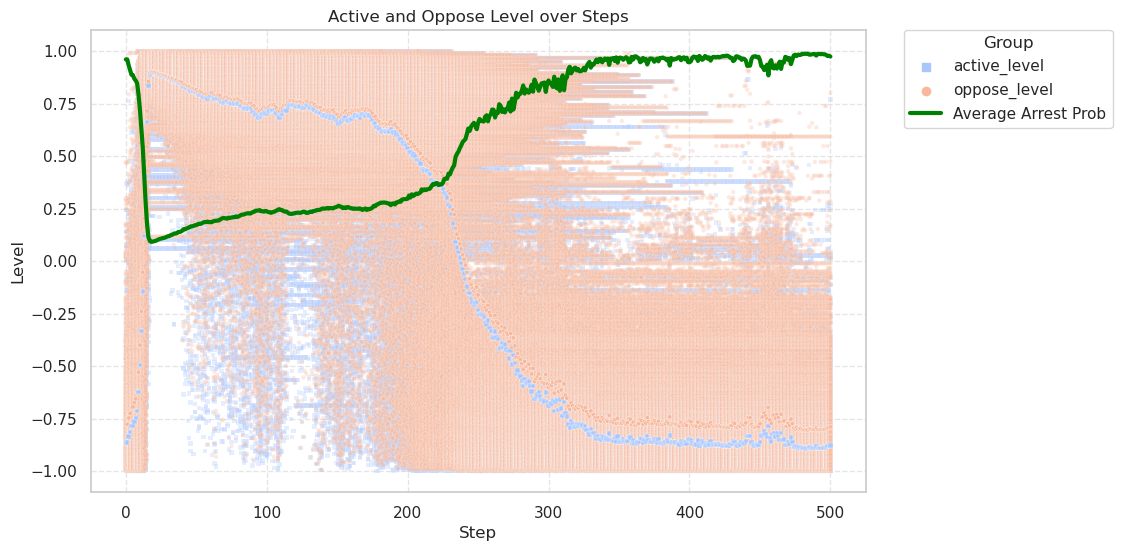

In [64]:
df = ag_df_2

# Reset the index to get the 'Step' column
df_reset = df.reset_index()

# Create a long format DataFrame suitable for seaborn
df_long = df_reset.melt(id_vars=['Step'], value_vars=['active_level', 'oppose_level'], var_name='Group', value_name='Level')

# Scatterplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

full_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette="coolwarm", style="Group",
                             s=10, alpha=0.3, markers={"active_level": "s", "oppose_level": "o"},
                             data=df_long).set(title='Active and Oppose Level over Steps')

# Calculate the average levels for each group
batch_avgs = df_long.groupby(["Step", "Group"]).mean().reset_index()

# Plot the averages
avg_data = sns.scatterplot(x="Step", y="Level", hue="Group", palette="coolwarm", style="Group", s=10,
                           markers={"active_level": "s", "oppose_level": "o"}, data=batch_avgs, legend=False)

# Calculate the average arrest_prob for each step
avg_arrest_prob = df_reset.groupby('Step')['arrest_prob'].mean()

# Plot the average arrest_prob
plt.plot(avg_arrest_prob.index, avg_arrest_prob, color='green', linewidth=3, label='Average Arrest Prob')

# Add a legend
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [87]:
number_of_unique_top_level_values = ag_df_1.index.get_level_values(0).nunique()
print("Number of unique top-level index values:", number_of_unique_top_level_values)


Number of unique top-level index values: 99
